<a href="https://colab.research.google.com/github/IA2021UR/practica-10-joferne/blob/main/practica10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 10.2: Filtrado colaborativo
 
En este notebook vamos a utilizar las técnicas de filtrado colaborativo para realizar predicciones sobre películas, en concreto queremos ser capaces de predecir la valoración de un usuario para una película que no haya visto. Para ello vamos a usar el dasaset [MovieLens](https://www.kaggle.com/grouplens/movielens-20m-dataset).

Este notebook está basado en el curso sobre embeddings de [Kaggle](https://www.kaggle.com/learn/embeddings). 

## Preparando el entorno

Comenzamos descargando el dataset que consta de dos ficheros. El fichero movie.csv contiene información sobre las distintas películas de nuestro dataset y el fichero rating.csv contiene las valoraciones. 

In [1]:
!wget https://www.dropbox.com/s/85ypr2uh1nj9ifr/movie.csv?dl=0 -O movie.csv
!wget https://www.dropbox.com/s/00rfbh4rfwte4is/rating.csv?dl=0 -O rating.csv

--2021-05-14 07:27:18--  https://www.dropbox.com/s/85ypr2uh1nj9ifr/movie.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/85ypr2uh1nj9ifr/movie.csv [following]
--2021-05-14 07:27:18--  https://www.dropbox.com/s/raw/85ypr2uh1nj9ifr/movie.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4149486b6fbdecbdcb15fde071.dl.dropboxusercontent.com/cd/0/inline/BOdPIR_v58MgWvhfCPMqn4B266yRGDFagot7hqfSIOSdeHWNatzVShDNUqe2NFPJ6H2ZogYLAnmS28RqoZmCcQyt0YTh9PcnW6XGi4_k8v-Wj-s7gApNcC9mWHkFMfF5yWKz4sdBPhwFFhjYCH0SKOTc/file# [following]
--2021-05-14 07:27:18--  https://uc4149486b6fbdecbdcb15fde071.dl.dropboxusercontent.com/cd/0/inline/BOdPIR_v58MgWvhfCPMqn4B266yRGDFagot7hqfSIOSdeHWNatzVShDNUqe2NFPJ6H2ZogYLAnmS28RqoZmCcQyt0YTh9P

Importamos a continuación las librerías que van a ser necesarias. En concreto, la librería más relevante que vamos a usar es la de Keras que será la que utilicemos para construir nuestro modelo. 

In [2]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

TensorFlow 1.x selected.


Vamos a fijar las semillas de cara a poder reproducir los resultados. 

In [3]:
tf.set_random_seed(1)
np.random.seed(1)
random.seed(1)

Cargamos los datos de los dos ficheros csv que hemos descargado anteriormente en dos dataframes usando la librería pandas. 

In [4]:
ratings_df = pd.read_csv('rating.csv', usecols=['userId', 'movieId', 'rating', 'y'])
movies_df = pd.read_csv('movie.csv', usecols=['movieId', 'title', 'year','genres','n_ratings'])

Combinamos ambos ficheros y mostramos una pequeña muestra de los mismos. 

In [5]:
df = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')
df = df.sample(frac=1, random_state=1)
df.sample(5, random_state=1)

,userId,movieId,rating,y,title,genres,year,n_ratings
12904240,85731,1883,4.5,0.974498,Labyrinth,Adventure|Fantasy|Musical,1986,8305
6089380,45008,1221,4.5,0.974498,"Femme Nikita, La (Nikita)",Action|Crime|Romance|Thriller,1990,9227
17901393,125144,3948,4.0,0.474498,The Alamo,Action|Drama|War|Western,1960,623
9024816,122230,3027,3.5,-0.025502,Toy Story 2,Adventure|Animation|Children|Comedy|Fantasy,1999,22770
11655659,21156,5202,3.0,-0.525502,My Big Fat Greek Wedding,Comedy|Romance,2002,10190


Como hemos comentado en teoría, es importante notar que podemos tener cientos de usuarios y películas por lo que vamos a utilizar embeddings para representar a cada uno de ellos. En concreto, a continuación se muestra el número de películas y de usuarios de nuestro dataset. 

In [6]:
print("Número de usuarios:", len(df.userId.unique()))

Número de usuarios: 138493


In [7]:
print("Número de películas:", len(df.movieId.unique()))

Número de películas: 26744


## Modelos de filtrado colaborativo

Vamos a construir dos modelos, uno basado en una red neuronal y otro que va a utilizar el producto escalar, pero antes de eso vamos a construir dos modelos sencillos. 

## Modelo base

Para ver cómo de bueno son los modelos que construyamos vamos a compararlo con dos modelos un poco tontos. Uno de ello devuelve siempre la media de las valoraciones de todas las películas y el otro devuelve la valoración media de una película concreta.  

Comenzamos partiendo el dataset en dos subcojuntos: el de entrenamiento y el de validación. 

In [8]:
df_train, df_val = train_test_split(df, test_size=.05, random_state=1)

Definimos las métricas que vamos a utilizar, que son las que utilizamos para problemas de regresión. 

In [9]:
def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

Definimos primero un modelo tonto que devuelve siempre la media de las valoraciones de todas las películas. 

In [10]:
mean_rating = df_train['rating'].mean()
print("La valoración media en el conjunto de entrenamiento es {:.2f} estrellas".format(mean_rating))

La valoración media en el conjunto de entrenamiento es 3.53 estrellas


Ahora calculamos cuál es el error que se produce utilizando este modelo.

In [11]:
y_true = df_val['rating'].values
always_mean = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, always_mean)
print("Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Mean Absolute Error=0.84, Mean Squared Error=1.10


El segundo modelo es el que devuelve la media de valoraciones de una película.

In [12]:
movies = movies_df.copy().set_index('movieId')
mean_per_movie = df_train.groupby('movieId')['rating'].mean()
movies['mean_rating'] = mean_per_movie
ratings_per_movie = df_train.groupby('movieId').size()
movies['n_ratings'] = ratings_per_movie
# En el caso de películas que no estén en el conjunto de entrenamiento se usa la media global
y_movie_mean = df_val.join(mean_per_movie, on='movieId', rsuffix='mean')['ratingmean'].fillna(mean_rating).values

Y calculamos el error. 

In [13]:
mae, mse = get_metrics(y_true, y_movie_mean)
print("Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Mean Absolute Error=0.73, Mean Squared Error=0.88




### Modelo red neuronal

El modelo de red neuronal que vamos a implementar tiene el siguiente aspecto. 

<img src="https://i.imgur.com/Z1eVQu9.png"/>

Notar que en este modelo no estamos solo apilando capas, por lo tanto no vamos a poder utilizar la API secuencial de Keras sino que será necesario utilizar la API funcional. 

Cada instancia de entrada de nuestro modelo va a constar de dos entradas: un identificador de usuario y un identificador de película. 

In [14]:
user_id_input = keras.Input(shape=(1,),name='user_id')
movie_id_input = keras.Input(shape=(1,),name='movie_id')

A cada una de estas componentes de la entrada le vamos a aplicar una capa de embedding, usando como tamaño de embedding un vector de 32 componentes. 

In [15]:
movie_embedding_size = 32
user_embedding_size = 32

user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Concatenamos los embeddings, y aplanamos. 

In [16]:
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

A continuación añadimos dos capas ocultas, una con 32 neuronas y otra con 4.

In [17]:
out = keras.layers.Dense(32, activation='relu')(out)
out = keras.layers.Dense(4, activation='relu')(out)

La última capa será la capa de predicción. 

In [18]:
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

Finalmente se combina el modelo definiendo las entradas y salidas. 

In [19]:
modelNN = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)

Como en todos los modelos de Keras debemos primero compilarlo indicando la función de pérdida que vamos a utilizar.

In [20]:
modelNN.compile(tf.train.AdamOptimizer(0.005),loss='MSE',metrics=['MAE'])

Y comenzamos el entrenamiento del modelo. 

In [21]:
historyNN = modelNN.fit([df.userId, df.movieId],df.y,batch_size=100000,epochs=20,validation_split=.05)

Train on 19000249 samples, validate on 1000014 samples
Epoch 1/20
19000249/19000249 [==============================] - 11s 1us/sample - loss: 0.7515 - mean_absolute_error: 0.6656 - val_loss: 0.7033 - val_mean_absolute_error: 0.6406
Epoch 2/20
19000249/19000249 [==============================] - 9s 0us/sample - loss: 0.6791 - mean_absolute_error: 0.6311 - val_loss: 0.6819 - val_mean_absolute_error: 0.6281
Epoch 3/20
19000249/19000249 [==============================] - 9s 0us/sample - loss: 0.6476 - mean_absolute_error: 0.6156 - val_loss: 0.6686 - val_mean_absolute_error: 0.6226
Epoch 4/20
19000249/19000249 [==============================] - 9s 0us/sample - loss: 0.6202 - mean_absolute_error: 0.6021 - val_loss: 0.6537 - val_mean_absolute_error: 0.6147
Epoch 5/20
19000249/19000249 [==============================] - 9s 0us/sample - loss: 0.5967 - mean_absolute_error: 0.5904 - val_loss: 0.6567 - val_mean_absolute_error: 0.6186
Epoch 6/20
19000249/19000249 [==============================] - 

A continuación se muestra una gráfica del entrenamiento de nuestro modelo. 

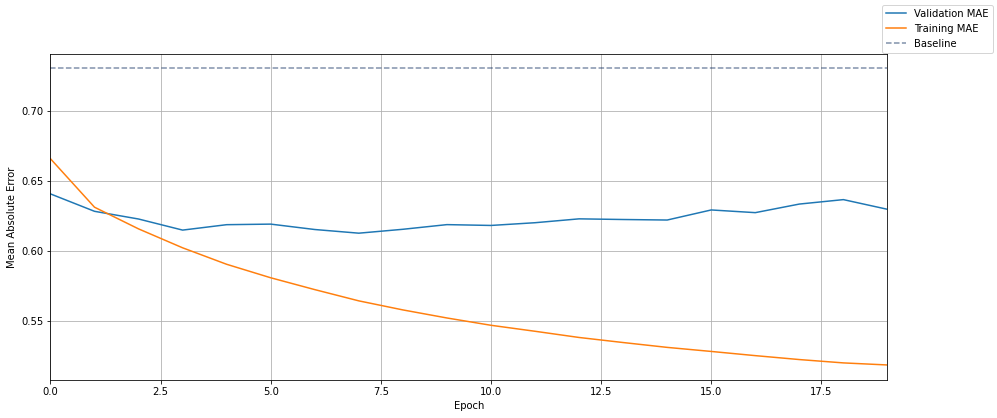

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(historyNN.epoch, historyNN.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(historyNN.epoch, historyNN.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=historyNN.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

En la gráfica anterior podemos ver que nuestro modelo basado en red neuronal es bastante mejor que el modelo base que habíamos definido anteriormente. Pero también nos damos cuenta que se produce cierto overfitting a partir de la segunda época (mientras que el error de entrenamiento sigue disminuyendo, el error de validación se estanca o incluso empieza a aumentar).

Vamos ahora a realizar algunas predicciones. En concreto, elegimos un usuario de manera aleatoria y mostramos las películas que ha valorado. 

In [23]:
ratings_per_user = df.groupby('userId').size()
uid = ratings_per_user[ratings_per_user < 30].sample(1, random_state=1).index[0]
user_ratings = df[df.userId==uid]
print("User #{} has rated {} movies (avg. rating = {:.1f}):".format(
    uid, len(user_ratings), user_ratings['rating'].mean(),
))
cols = ['userId', 'movieId', 'rating', 'title', 'year']
user_ratings.sort_values(by='rating', ascending=False)[cols]

User #26556 has rated 21 movies (avg. rating = 3.7):


,userId,movieId,rating,title,year
4421455,26556,2705,5.0,Airplane!,1980
14722970,26556,2706,5.0,Airplane II: The Sequel,1982
7435440,26556,2286,4.5,Fletch,1985
16621016,26556,2216,4.5,History of the World: Part I,1981
11648630,26556,534,4.5,Six Degrees of Separation,1993
14805184,26556,937,4.5,Mr. Smith Goes to Washington,1939
14313285,26556,2102,4.5,Strangers on a Train,1951
13671173,26556,2863,4.5,Dr. No,1962
13661434,26556,913,4.0,Notorious,1946
11938282,26556,916,4.0,To Catch a Thief,1955


Podemos ahora ver la predicción que haría este usuario para algunas películas. Definimos la lista de películas para las cuales vamos a obtener una valoración. Por ejemplo podemos ver que a nuestro usuario le gustó especialmente la saga de películas AirPlane (en España ¡aterriza como puedas!), por lo que podemos esperar que también le gusten las películas de la serie Agarraló como puedas, en inglés The Naked gun, protagonizadas también por Leslie Nielsen.

In [24]:
candidate_movies = movies[
    movies.title.str.contains('The Godfather')
    | (movies.title == 'Toy Story')
    | (movies.title.str.contains('Naked Gun'))
].copy()

Realizamos la predicción. Para ello le pasamos al modelo un par con dos listas: la primera es una lista en la que hemos repetido varias veces el identificador de nuestro usuario, y la segunda es lista de películas para las cuales queremos obtener la valoración. 

In [25]:
preds = modelNN.predict([
    [uid] * len(candidate_movies),
    candidate_movies.index,
])

Como la predicción se hace centrada en 0 debemos transformar dicha predicción para obtener un valor entre 0.5 y 5. 

In [26]:
row = df.iloc[0]
y_delta = row.rating - row.y
candidate_movies['predicted_rating'] = preds + y_delta
candidate_movies['delta'] = candidate_movies['predicted_rating'] - candidate_movies['mean_rating']
candidate_movies.sort_values(by='delta', ascending=False)

,title,genres,year,n_ratings,mean_rating,predicted_rating,delta
movieId,,,,,,,
366,Naked Gun 33 1/3: The Final Insult,Action|Comedy,1994,13534.0,2.954226,3.668269,0.714043
3776,The Naked Gun 2 1/2: The Smell of Fear,Comedy,1991,4415.0,3.132616,3.664445,0.531829
3775,The Naked Gun: From the Files of Police Squad!,Action|Comedy|Crime|Romance,1988,6973.0,3.580381,4.109317,0.528935
843,The Godfather,Crime|Drama,1972,39313.0,4.364193,3.863141,-0.501051
1195,The Godfather: Part II,Crime|Drama,1974,26013.0,4.275343,3.563613,-0.711730
0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,47251.0,3.919377,3.091516,-0.827862
1939,The Godfather: Part III,Crime|Drama|Mystery|Thriller,1990,9647.0,3.410905,2.143704,-1.267201


Vamos a guardar los pesos de este modelo por si los necesitamos en el futuro. 

In [27]:
modelNN.save_weights('./modelNN.h5', overwrite=True)

**Ejercicio**

Crea y entrena un nuevo modelo que use como tamaño de embedding 64, además el modelo tendrá tres capas ocultas después de concatenar los dos embeddings, una de 64 capas seguida de una de 8 y por último una de 4, además como en el caso anterior será necesaria una última capa para predecir. ¿Se obtienen mejores resultados con este nuevo modelo?  

Train on 19000249 samples, validate on 1000014 samples
Epoch 1/20
19000249/19000249 [==============================] - 10s 1us/sample - loss: 0.7511 - mean_absolute_error: 0.6646 - val_loss: 0.6973 - val_mean_absolute_error: 0.6420
Epoch 2/20
19000249/19000249 [==============================] - 10s 1us/sample - loss: 0.6705 - mean_absolute_error: 0.6266 - val_loss: 0.6820 - val_mean_absolute_error: 0.6373
Epoch 3/20
19000249/19000249 [==============================] - 10s 1us/sample - loss: 0.6368 - mean_absolute_error: 0.6101 - val_loss: 0.6589 - val_mean_absolute_error: 0.6218
Epoch 4/20
19000249/19000249 [==============================] - 10s 1us/sample - loss: 0.6032 - mean_absolute_error: 0.5934 - val_loss: 0.6602 - val_mean_absolute_error: 0.6123
Epoch 5/20
19000249/19000249 [==============================] - 10s 1us/sample - loss: 0.5746 - mean_absolute_error: 0.5789 - val_loss: 0.6535 - val_mean_absolute_error: 0.6168
Epoch 6/20
19000249/19000249 [==============================

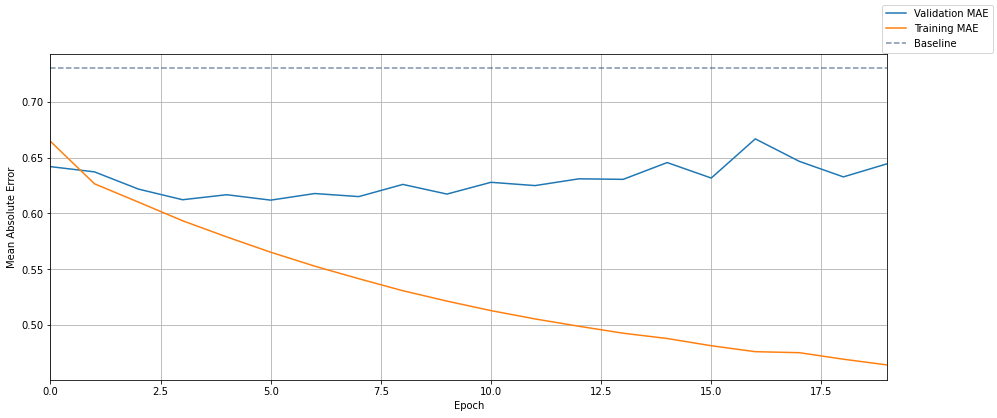

In [28]:
user_id_input = keras.Input(shape=(1,),name='user_id')
movie_id_input = keras.Input(shape=(1,),name='movie_id')

movie_embedding_size = 64
user_embedding_size = 64

user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dense(8, activation='relu')(out)
out = keras.layers.Dense(4, activation='relu')(out)

out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

modelNN = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)

modelNN.compile(tf.train.AdamOptimizer(0.005),loss='MSE',metrics=['MAE'])

historyNN = modelNN.fit([df.userId, df.movieId],df.y,batch_size=100000,epochs=20,validation_split=.05)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(historyNN.epoch, historyNN.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(historyNN.epoch, historyNN.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=historyNN.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

Notamos que ciertamente hay algo más de sobreajuste, aunque los resultados son similares.

## Modelo producto escalar

Vamos a considerar ahora un modelo más sencillo basado en el producto escalar. A esta arquitectura también se la suele llamar factorización de matrices. En concreto nuestro modelo de factorización será algo similar a lo siguiente. 

<img src="https://i.imgur.com/lUzvCHj.png">


De nuevo vamos a construir nuestro modelo con Keras. Comenzamos definiendo el tamaño de nuestro embedding. 

In [29]:
movie_embedding_size = user_embedding_size = 32

De nuevo cada instancia de nuestro dataset va a constar de dos entradas: el id del usuario y el de la película. 

In [30]:
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')

Ambas entradas van a pasar a través de su respectiva capa de embedding. 

In [31]:
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

A continuación se añade una capa encargada de realizar el producto escalar y a continuación el resultado se aplana.

In [32]:
dotted = keras.layers.Dot(2)([user_embedded, movie_embedded])
out = keras.layers.Flatten()(dotted)

Definimos el modelo

In [33]:
modelDot = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)

y lo compilamos. 

In [34]:
modelDot.compile(tf.train.AdamOptimizer(0.001),loss='MSE',metrics=['MAE'])

Por último vamos a entrenarlo. 

In [35]:
historyDot = modelDot.fit([df.userId, df.movieId],df.y,batch_size=100000,epochs=20,validation_split=.05)

Train on 19000249 samples, validate on 1000014 samples
Epoch 1/20
19000249/19000249 [==============================] - 12s 1us/sample - loss: 1.0892 - mean_absolute_error: 0.8332 - val_loss: 0.9936 - val_mean_absolute_error: 0.7897
Epoch 2/20
19000249/19000249 [==============================] - 12s 1us/sample - loss: 0.8358 - mean_absolute_error: 0.7071 - val_loss: 0.7525 - val_mean_absolute_error: 0.6645
Epoch 3/20
19000249/19000249 [==============================] - 12s 1us/sample - loss: 0.7137 - mean_absolute_error: 0.6463 - val_loss: 0.7091 - val_mean_absolute_error: 0.6430
Epoch 4/20
19000249/19000249 [==============================] - 12s 1us/sample - loss: 0.6758 - mean_absolute_error: 0.6276 - val_loss: 0.6865 - val_mean_absolute_error: 0.6316
Epoch 5/20
19000249/19000249 [==============================] - 12s 1us/sample - loss: 0.6489 - mean_absolute_error: 0.6142 - val_loss: 0.6696 - val_mean_absolute_error: 0.6232
Epoch 6/20
19000249/19000249 [==============================

Ahora, vamos a comparar gráficamente los tres modelos: el básico, el construido usando una red neuronal y el construido usando el producto escalar. 

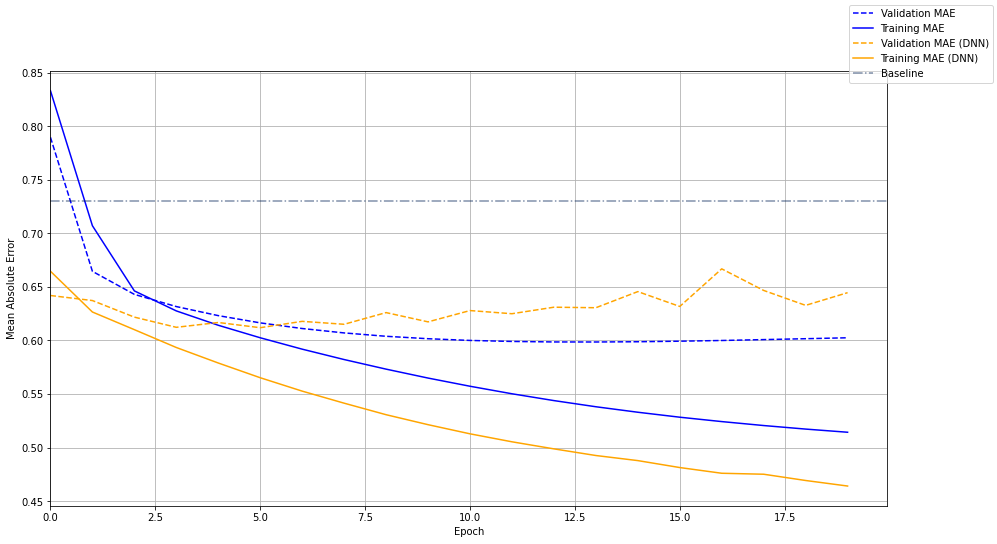

In [36]:
fig, ax = plt.subplots(figsize=(15, 8))
c1 = 'blue'
ax.plot(historyDot.epoch, historyDot.history['val_mean_absolute_error'], '--', label='Validation MAE', color=c1)
ax.plot(historyDot.epoch, historyDot.history['mean_absolute_error'], label='Training MAE', color=c1)

c2 = 'orange'
ax.plot(historyNN.epoch, historyNN.history['val_mean_absolute_error'], '--', label='Validation MAE (DNN)', color=c2)
ax.plot(historyNN.epoch, historyNN.history['mean_absolute_error'], label='Training MAE (DNN)', color=c2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0)
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='-.', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

Como se puede apreciar el modelo basado en el producto escalar también funciona bastante bien, aunque también sufre el problema del overfitting. 

**Ejercicio**

Utilizando esta técnica crea un modelo que use como tamaño de embedding 16.


Train on 19000249 samples, validate on 1000014 samples
Epoch 1/20
19000249/19000249 [==============================] - 12s 1us/sample - loss: 1.0975 - mean_absolute_error: 0.8368 - val_loss: 1.0424 - val_mean_absolute_error: 0.8125
Epoch 2/20
19000249/19000249 [==============================] - 12s 1us/sample - loss: 0.9017 - mean_absolute_error: 0.7398 - val_loss: 0.8007 - val_mean_absolute_error: 0.6876
Epoch 3/20
19000249/19000249 [==============================] - 11s 1us/sample - loss: 0.7527 - mean_absolute_error: 0.6650 - val_loss: 0.7381 - val_mean_absolute_error: 0.6571
Epoch 4/20
19000249/19000249 [==============================] - 12s 1us/sample - loss: 0.7114 - mean_absolute_error: 0.6451 - val_loss: 0.7172 - val_mean_absolute_error: 0.6469
Epoch 5/20
19000249/19000249 [==============================] - 12s 1us/sample - loss: 0.6912 - mean_absolute_error: 0.6352 - val_loss: 0.7038 - val_mean_absolute_error: 0.6402
Epoch 6/20
19000249/19000249 [==============================

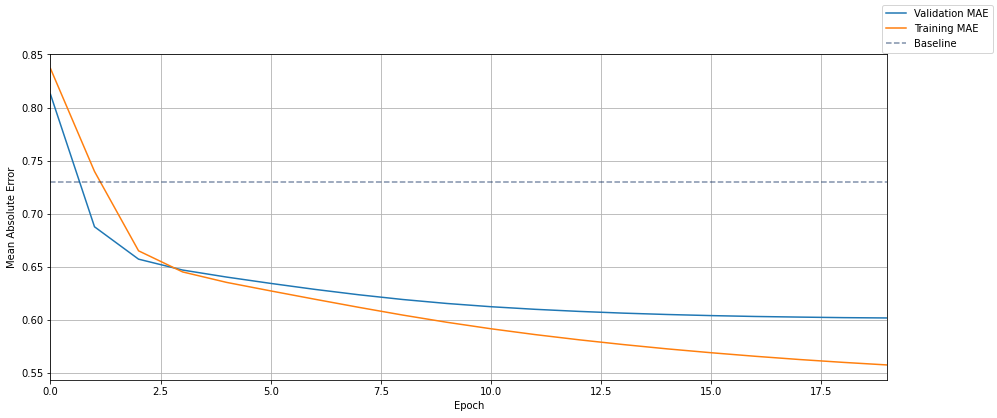

In [37]:
movie_embedding_size = user_embedding_size = 16

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')

user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

dotted = keras.layers.Dot(2)([user_embedded, movie_embedded])
out = keras.layers.Flatten()(dotted)

modelDot = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)

modelDot.compile(tf.train.AdamOptimizer(0.001),loss='MSE',metrics=['MAE'])

historyDot = modelDot.fit([df.userId, df.movieId],df.y,batch_size=100000,epochs=20,validation_split=.05)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(historyDot.epoch, historyDot.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(historyDot.epoch, historyDot.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=historyDot.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

**Ejercicio opcional**

En el notebook practica10_1 hemos visto cómo aplicar la técnica de Dropout para reducir el overfitting. En Keras es posible aplicar esta técnica. Investiga cómo añadir una capa de Dropout a los modelos que hemos creado.

Train on 19000249 samples, validate on 1000014 samples
Epoch 1/20
19000249/19000249 [==============================] - 10s 1us/sample - loss: 0.8602 - mean_absolute_error: 0.7213 - val_loss: 0.7710 - val_mean_absolute_error: 0.6933
Epoch 2/20
19000249/19000249 [==============================] - 10s 1us/sample - loss: 0.8054 - mean_absolute_error: 0.6970 - val_loss: 0.7211 - val_mean_absolute_error: 0.6554
Epoch 3/20
19000249/19000249 [==============================] - 10s 1us/sample - loss: 0.7869 - mean_absolute_error: 0.6881 - val_loss: 0.7067 - val_mean_absolute_error: 0.6490
Epoch 4/20
19000249/19000249 [==============================] - 10s 1us/sample - loss: 0.7692 - mean_absolute_error: 0.6795 - val_loss: 0.7073 - val_mean_absolute_error: 0.6524
Epoch 5/20
19000249/19000249 [==============================] - 10s 1us/sample - loss: 0.7502 - mean_absolute_error: 0.6704 - val_loss: 0.6689 - val_mean_absolute_error: 0.6294
Epoch 6/20
19000249/19000249 [==============================

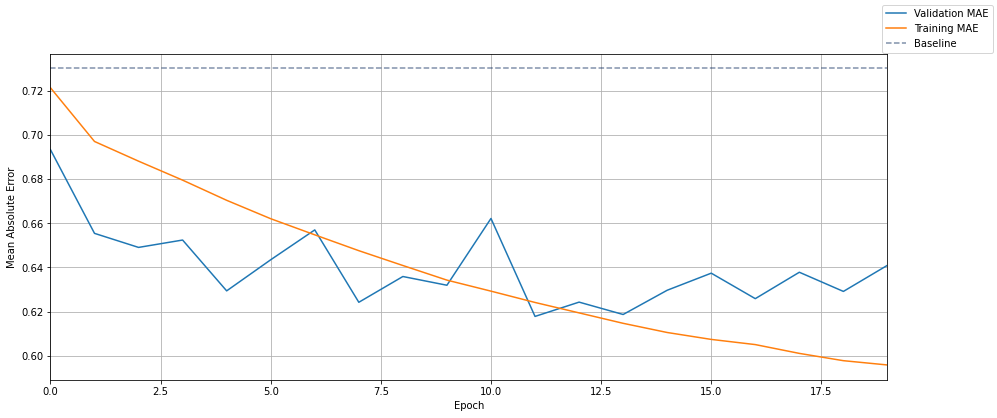

In [38]:
user_id_input = keras.Input(shape=(1,),name='user_id')
movie_id_input = keras.Input(shape=(1,),name='movie_id')

movie_embedding_size = 64
user_embedding_size = 64

user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dense(8, activation='relu')(out)
out = keras.layers.Dense(4, activation='relu')(out)
out = keras.layers.Dropout(0.4)(out) # Añadimos Dropout en última capa

out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

modelNN = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)

modelNN.compile(tf.train.AdamOptimizer(0.005),loss='MSE',metrics=['MAE'])

historyNN = modelNN.fit([df.userId, df.movieId],df.y,batch_size=100000,epochs=20,validation_split=.05)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(historyNN.epoch, historyNN.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(historyNN.epoch, historyNN.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=historyNN.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

## Comprendiendo los embeddings

Durante el curso hemos explicado que los embeddings son capaces de capturar el "significado" de los objetos que representan y que pueden usarse para descubrir la estructura subyacente de los mismos. Vamos a ver qué significa esto. Para ello vamos a considerar el modelo construido mediante la red neuronal (podríamos hacer lo mismo con el construido mediante el producto escalar).

Como hemos visto anteriormente hay dos embeddings el de las películas y el de los usuarios. Nosotros nos centraremos en el primero de ellos. Para acceder a dicho embedding debemos acceder a las "tripas" de nuestro modelo. En concreto debemos obtener los pesos de la capa de embedding.

In [39]:
emb_layer = modelNN.get_layer('movie_embedding')
(w,) = emb_layer.get_weights()

Veámos la forma de dichos pesos. 

In [40]:
w.shape

(26744, 64)

Como podemos apreciar tenemos una lista de 26744 vectores (uno por cada película del dataset), y cada vector consta de 32 componentes (el tamaño del embedding que hemos definido previamente). Por lo tanto podemos ver el embedding de alguna de nuestras películas, por ejemplo de la primera del dataset. 

In [41]:
w[0]

array([ 5.6186367e-02,  5.9708929e-01,  3.1584805e-01,  5.7963842e-01,
        8.5131846e-02, -7.9638565e-01, -4.8207749e-02,  4.7812855e-01,
        6.7798449e-03, -1.5787402e-02,  1.5293045e-01, -4.0699828e-01,
       -1.9969608e-01,  2.2262093e-01, -6.0108319e-02,  1.5187067e-01,
       -3.4648022e-01,  3.1308584e-02,  3.4827763e-01, -4.8112893e-01,
        6.4851964e-01,  5.3156495e-01,  2.7755147e-01, -1.9865954e-02,
       -3.6427310e-01,  2.3367763e-01, -4.5485112e-01, -4.2878529e-01,
        2.2120847e-01, -1.7853120e-01, -9.9089459e-02, -2.3149255e-01,
       -9.4485655e-02, -5.9810369e-03,  3.9959589e-01,  1.3693532e-01,
       -5.5487812e-01,  3.0535352e-01, -4.6910346e-04, -1.5477388e-01,
       -4.1718316e-01, -1.4480147e-01,  1.5558609e-01,  3.6921960e-01,
        4.7597319e-02, -9.1688395e-02,  3.1115887e-01,  7.7415153e-02,
       -5.7008749e-01,  3.9033738e-01,  8.2348101e-02, -4.1416755e-01,
        3.5029730e-01,  2.2976065e-01,  1.4838013e-01,  4.1567108e-01,
      

Si mostramos las cinco primeras filas del dataset, podemos ver que dicho embedding se corresponde con la película Toy Story. 

In [42]:
movies_df.head()

,movieId,title,genres,year,n_ratings
0,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,49695
1,1,Jumanji,Adventure|Children|Fantasy,1995,22243
2,2,Grumpier Old Men,Comedy|Romance,1995,12735
3,3,Waiting to Exhale,Comedy|Drama|Romance,1995,2756
4,4,Father of the Bride Part II,Comedy,1995,12161


### Vectores de similaridad

Una manera de comprobar si la representación obtenida es correcta consiste en mirar como de lejanos o cercanos son pares de películas dentro del espacio de embedding. En caso de que el embedding sea lo suficientemente bueno debería ser capaz de decir que películas similares tienen vectores similares. 

Por ejemplo, vamos a considerar tres películas de nuestro dataset: Toy Story, El jorobado de Notre Dame y El exorcista. Si nuestro embedding es razonable debería indicar que Toy Story se encuentra más cerca del jorobado de Notre Dame que del exorcista. 

Para ver esto debemos comenzar obteniendo los identificadores de estas tres películas. 

In [43]:
i_toy_story = 0
i_notre_dame = movies_df.loc[movies_df.title == 'The Hunchback of Notre Dame','movieId'].iloc[0]
i_exorcist = movies_df.loc[movies_df.title == 'The Exorcist','movieId'].iloc[0]

Ahora obtenemos el embedding de cada uno de ellos. 

In [44]:
toy_story_vec = w[i_toy_story]
notre_dame_vec = w[i_notre_dame]
exorcist_vec = w[i_exorcist]

Podemos ahora medir la distancia usando la distancia coseno.

In [45]:
from scipy.spatial import distance

print("Distancia entre Toy Story y El Jorobado de Notre Dame: ", distance.cosine(toy_story_vec, notre_dame_vec))
print("Distancia entre Toy Story y El Exorcista: ", distance.cosine(toy_story_vec, exorcist_vec))

Distancia entre Toy Story y El Jorobado de Notre Dame:  0.6284500956535339
Distancia entre Toy Story y El Exorcista:  0.8277938812971115


Como podemos ver, tenemos un embedding razonable. Ahora, poremos hacernos preguntas como ¿Qué películas son las más parecidas a Toy Story? ¿Cuáles son películas completamente distintas a Scream? Para ello podeoms usar la librería [Gensim](https://radimrehurek.com/gensim/). Para ello instanciaremos la clase "WordEmbeddingsKeyedVectors" con el embedding que hemos construido anterioremente. 


In [46]:
from gensim.models.keyedvectors import WordEmbeddingsKeyedVectors

A continuación definimos nuestro embedding. 

In [47]:
movie_embedding_size = w.shape[1]
kv = WordEmbeddingsKeyedVectors(movie_embedding_size)
kv.add(
    movies_df['title'].values,
    w[movies_df.movieId]
)

Ahora podemos preguntar cuáles son las películas más similares a Toy Story con la siguiente instrucción. 

In [48]:
kv.most_similar('Toy Story')

[('Toy Story 2', 0.9117016792297363),
 ('Finding Nemo', 0.8645526766777039),
 ('Monsters, Inc.', 0.8395119905471802),
 ("A Bug's Life", 0.8106082677841187),
 ('The Incredibles', 0.7915245294570923),
 ('Toy Story 3', 0.780540943145752),
 ('The Whisperers', 0.7247568368911743),
 ('Ratatouille', 0.7060489654541016),
 ('In Name Only', 0.6778861880302429),
 ('Paulette', 0.6737214922904968)]

Como es de esperar, Toy Story es muy similar a Toy Story 2. Vamos a mostrar los vecions más cercanos para unas cuentas películas de distintos géneros. 

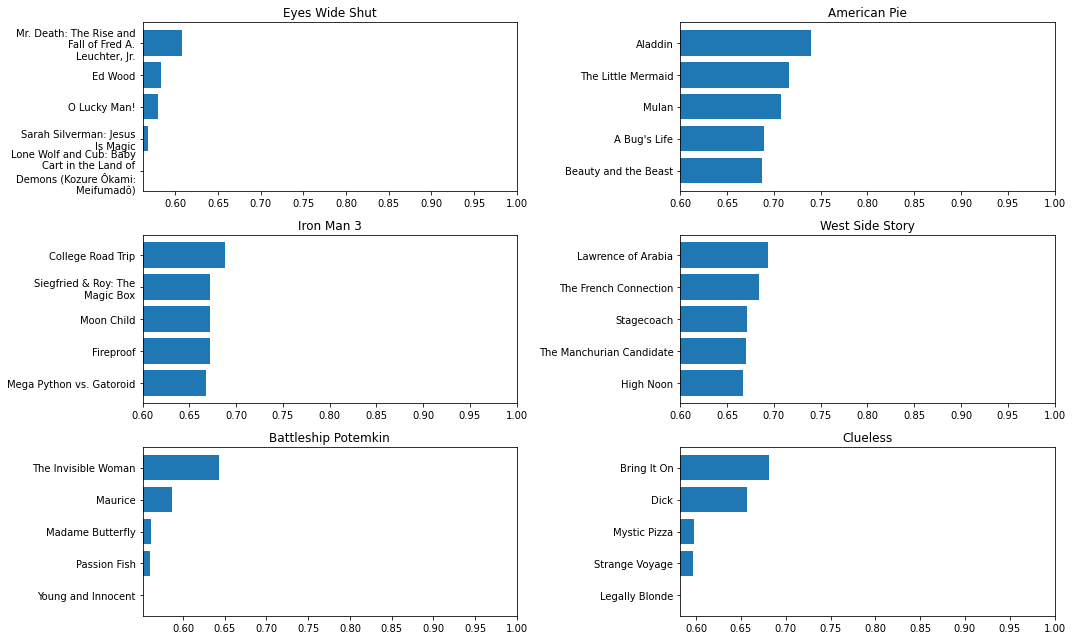

In [49]:
import textwrap
movies = ['Eyes Wide Shut', 'American Pie', 'Iron Man 3', 'West Side Story',
          'Battleship Potemkin', 'Clueless'
]

def plot_most_similar(movie, ax, topn=5):
    sim = kv.most_similar(movie, topn=topn)[::-1]
    y = np.arange(len(sim))
    w = [t[1] for t in sim]
    ax.barh(y, w)
    left = min(.6, min(w))
    ax.set_xlim(right=1.0, left=left)
    # Split long titles over multiple lines
    labels = [textwrap.fill(t[0] , width=24)
              for t in sim]
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_title(movie)    

fig, axes = plt.subplots(3, 2, figsize=(15, 9))

for movie, ax in zip(movies, axes.flatten()):
    plot_most_similar(movie, ax)
    
fig.tight_layout()

**Ejercicio**

¿Cuáles son las películas más parecidas a Scream?

In [50]:
kv.most_similar('Scream')

[('Everyone Says I Love You', 0.6353071928024292),
 ('Amu', 0.6331912279129028),
 ('Drop Dead Gorgeous', 0.5903620719909668),
 ('Strange Days', 0.5556501746177673),
 ('Pecker', 0.5555241107940674),
 ('Get on the Bus', 0.5461686253547668),
 ('Cradle Will Rock', 0.5461607575416565),
 ('Surviving Picasso', 0.5414868593215942),
 ('Crooklyn', 0.5356268882751465),
 ("King's Faith", 0.5352903008460999)]

## Visualizando los embeddings



La visualización de datos en 1 o 2 dimensiones es sencilla, pero no ocurre lo mismo cuando tenemos datos en 8 o 32 dimensiones. Para dichos casos se utilizan técnicas de reducción de dimensionalidad como ya hemos visto previamente en el curso. 

Vamos a utilizar la técnica [t-SNE](https://lvdmaaten.github.io/tsne/) para visualizar nuestro dataset. Como hay muchas películas en el mismo, nos vamos a quedar solo con aquellas que son populares. 


In [51]:
threshold = 100
mainstream_movies = movies_df[movies_df.n_ratings >= threshold].reset_index(drop=True)
print("Went from {} to {} movies after applying threshold".format(
    len(movies_df), len(mainstream_movies),
))
w_full = w
w = w[mainstream_movies.movieId]
df = mainstream_movies

Went from 26744 to 8546 movies after applying threshold


Aplicamos la técnica de t-SNE a nuestro dataset reducido. 

In [52]:
from sklearn.manifold import TSNE


tsne = TSNE(random_state=1, n_iter=1000, metric="cosine")

embs = tsne.fit_transform(w)
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

Una vez que hemos reducido la dimensionalidad de los embeddings de las películas podemos visualizarlos con el siguiente código. 

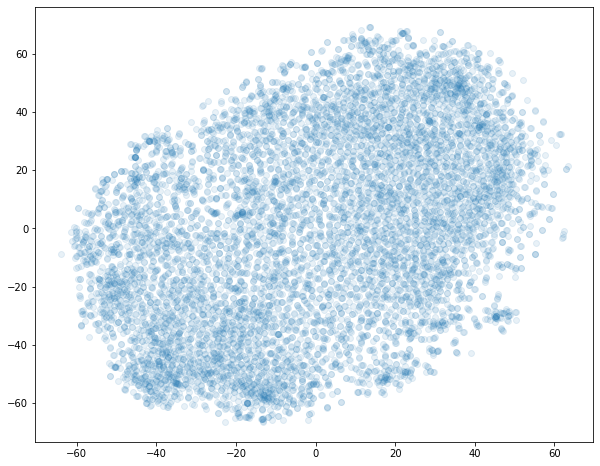

In [53]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
ax.scatter(df.x, df.y, alpha=.1)

Es difícil saber si la reducción de dimensionalidad ha sido útil solo por el aspecto de la nube de puntos anterior. Así que ahora vamos a intentar identificar grupos de películas que creemos que deberían estar cercanas en el espacio. Para ello es necesario definir una serie de funciones auxiliares que nos permitirán generar gráficos. 

In [54]:
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass
  
def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def annotate_sample(n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = mainstream_movies[mainstream_movies.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(sample.index)

def plot_by_title_pattern(pattern, **kwargs):
    """Plot all movies whose titles match the given regex pattern.
    """
    match = df[df.title.str.contains(pattern)]
    return plot_with_annotations(match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    if text:
        # TODO: Add abbreviated title column
        titles = mainstream_movies.loc[label_indices, 'title'].values
        texts = []
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, 
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(title, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given title. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df.title == title]
    assert len(match) == 1
    row = match.iloc[0]
    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)

Con las funciones anteriores podemos ver por ejemplo la cercanía de las películas de Harry Potter. 

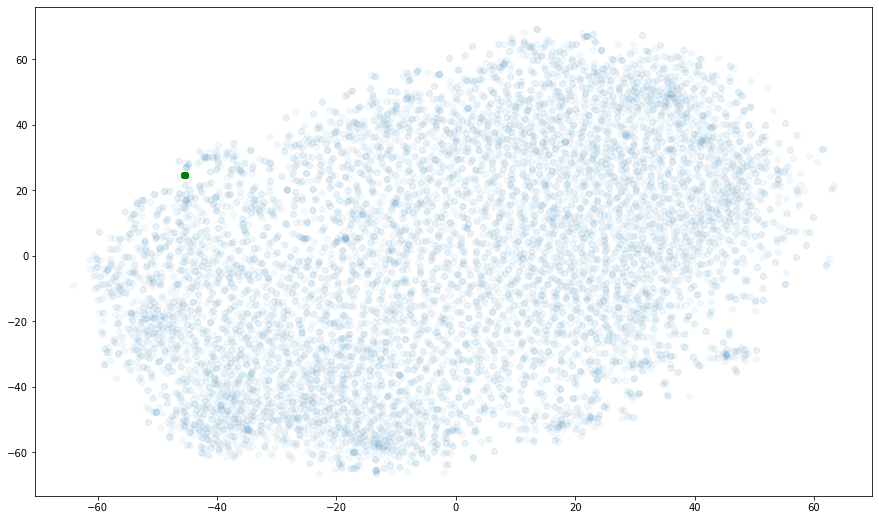

In [55]:
plot_by_title_pattern('Harry Potter', figsize=(15, 9), bg_alpha=.05, text=False);

El gráfico anterior muestra un punto verde donde están las 8 películas de Harry Potter pero están tan creca que es imposible apreciarlo. Por lo que podemos hacer zoom con la siguiente llamada. 

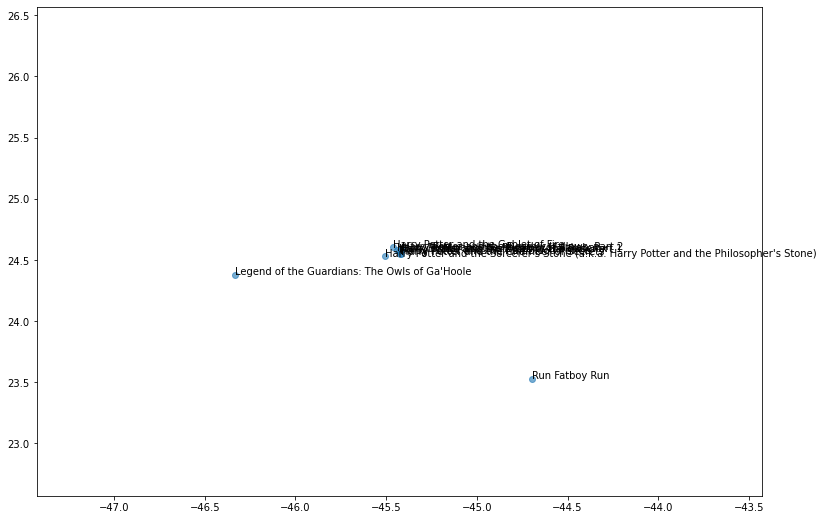

In [56]:
plot_region_around('Harry Potter and the Order of the Phoenix', 2);

Podemos aproximarnos un poco más a dicha región y como era de esperar las películas de Harry Potter están muy cercanas entre sí. 

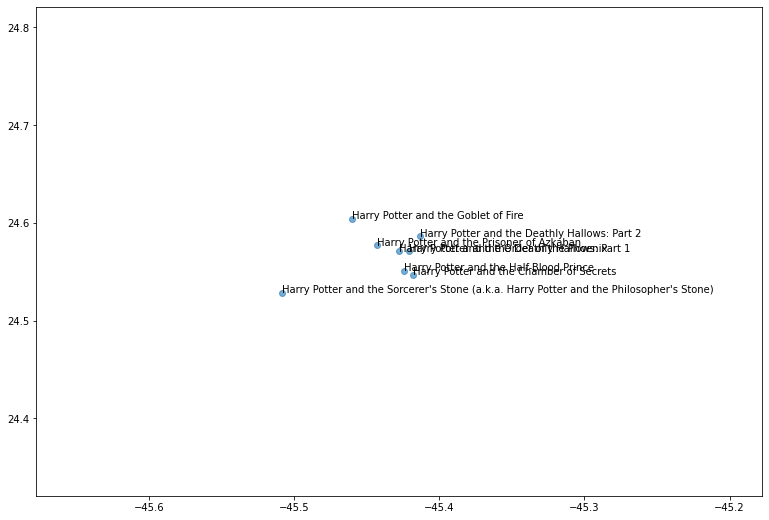

In [57]:
plot_region_around('Harry Potter and the Order of the Phoenix', 0.25);

**Ejercicio** Usando esta técnica busca las películas más cercanas a Toy Story.

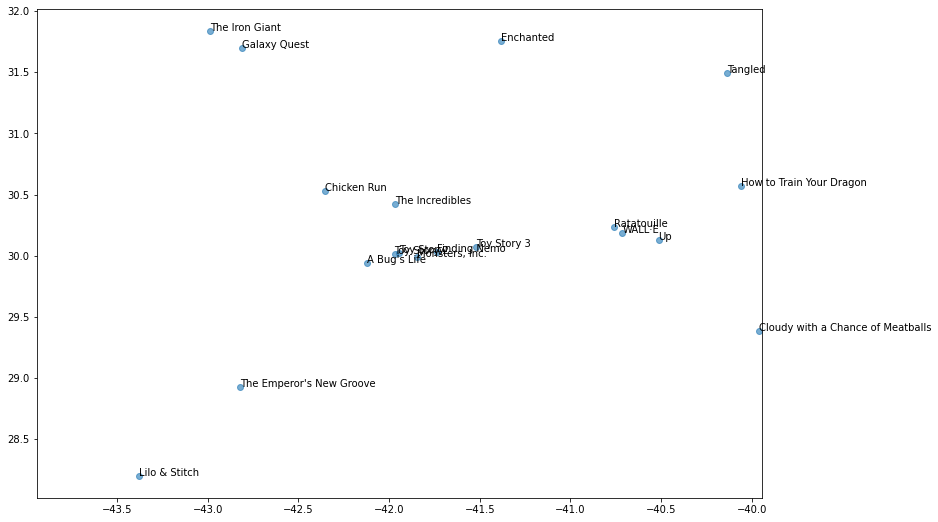

In [58]:
plot_region_around('Toy Story', 2);

También podemos buscar relaciones más generales, por ejemplo entre películas del mismo género. Por ejemplo, el siguiente código muestra cómo mostrar las películas del género Documental. 

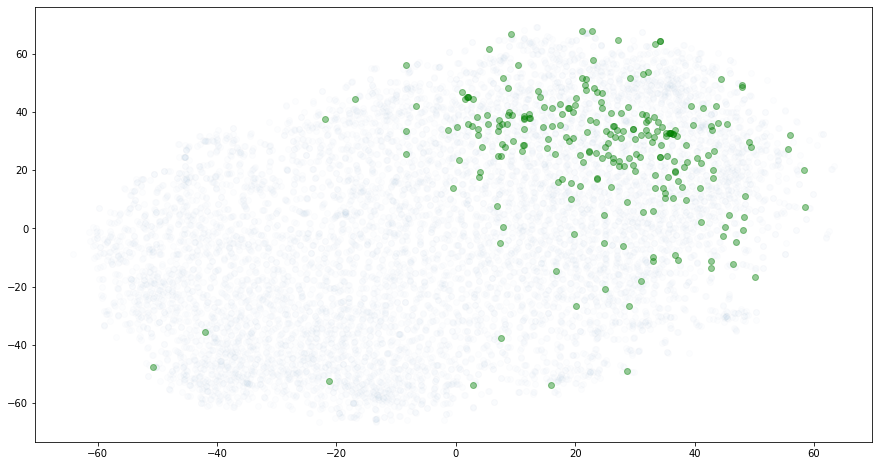

In [59]:
docs = df[ (df.genres == 'Documentary') ]
plot_with_annotations(docs.index, text=False, alpha=.4, figsize=(15, 8));

Aunque en la figura anterior no hay un clúster completamente definido, sí que podemos apreciar cierto patrón. 

También se puede repetir el mismo experimento visualizando todas aquellas películas que pertenecen a uno, o varios, de los géneros comedia, drama o romance. 

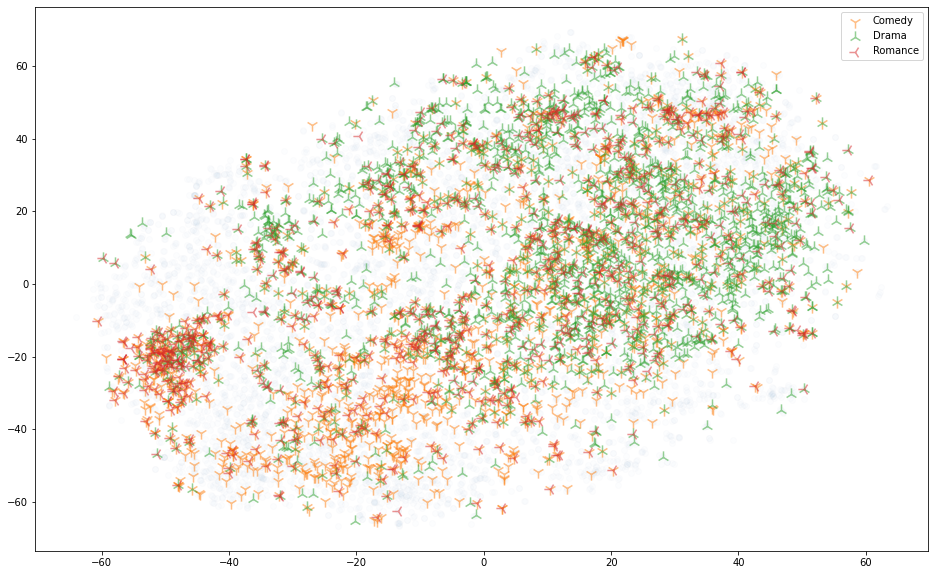

In [60]:
import itertools
sample_rate = 1
genre_components = ['Comedy', 'Drama', 'Romance']
genre_combos = set()
for size in range(1, 4):
    combo_strs = ['|'.join(genres) for genres in itertools.combinations(genre_components, size)]
    genre_combos.update(combo_strs)

ax = plot_bg(figsize=(16, 10))
dromcoms = df[df.genres.isin(genre_combos)]
if sample_rate != 1:
    dromcoms = dromcoms.sample(frac=sample_rate, random_state=1)
for i, genre in enumerate(genre_components):
    m = dromcoms[dromcoms.genres.str.contains(genre)]
    marker = str(i+1)
    add_annotations(ax, m.index, label=genre, alpha=.5, marker=marker, s=150, linewidths=5)
plt.legend();

Como podemos apreciar en la imagen anterior, las comedias y los dramas están en lados opuestos de la nube de puntos. 

**Ejercicio**

Usando la técnica anterior visualiza otros géneros y sus relaciones (puedes ver los géneros disponibles en el dataset inicial). 

In [61]:
df.genres

0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
8541                              Adventure|Fantasy
8542                                          Drama
8543                Children|Comedy|Fantasy|Musical
8544                                  Action|Comedy
8545                  Action|Adventure|Comedy|Crime
Name: genres, Length: 8546, dtype: object

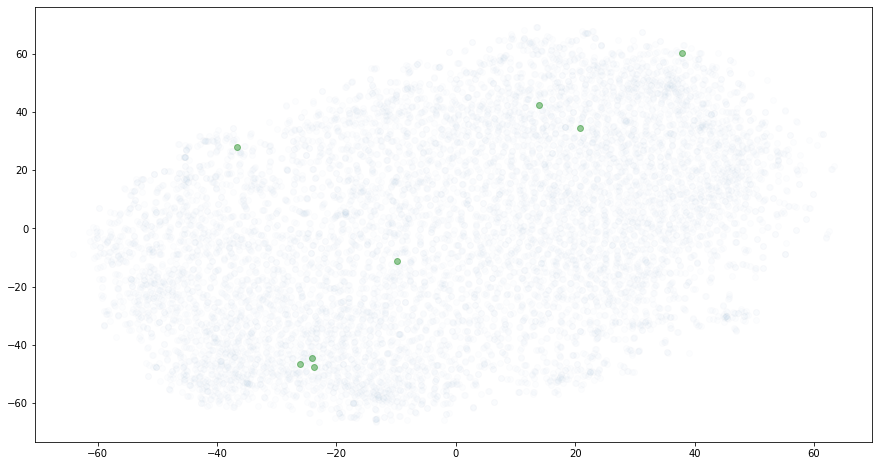

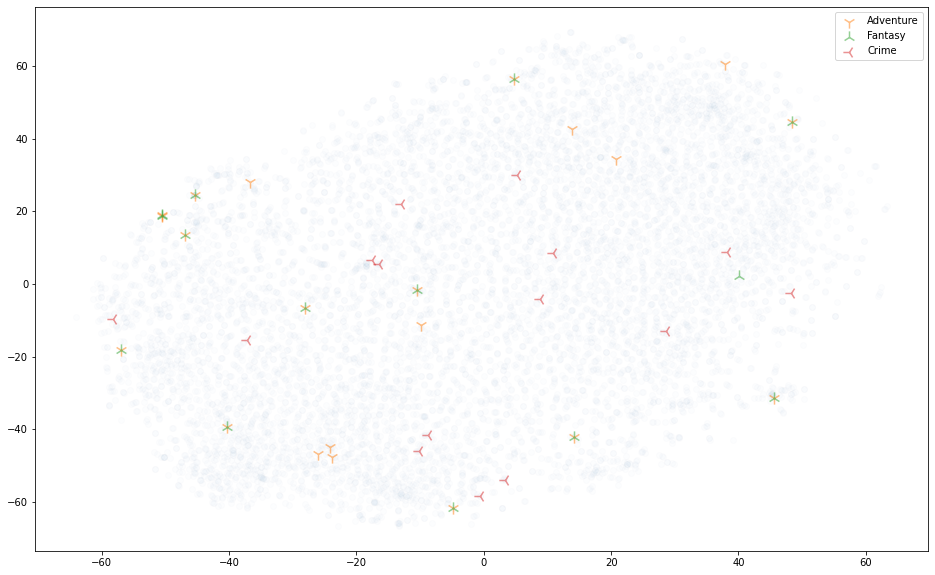

In [63]:
docs = df[ (df.genres == 'Adventure') ]
plot_with_annotations(docs.index, text=False, alpha=.4, figsize=(15, 8));

import itertools
sample_rate = 1
genre_components = ['Adventure', 'Fantasy', 'Crime']
genre_combos = set()
for size in range(1, 4):
    combo_strs = ['|'.join(genres) for genres in itertools.combinations(genre_components, size)]
    genre_combos.update(combo_strs)

ax = plot_bg(figsize=(16, 10))
dromcoms = df[df.genres.isin(genre_combos)]
if sample_rate != 1:
    dromcoms = dromcoms.sample(frac=sample_rate, random_state=1)
for i, genre in enumerate(genre_components):
    m = dromcoms[dromcoms.genres.str.contains(genre)]
    marker = str(i+1)
    add_annotations(ax, m.index, label=genre, alpha=.5, marker=marker, s=150, linewidths=5)
plt.legend();

**Ejercicio optativo**

Existen múltiples datasets en los cuales se puede aplicar filtrado colaborativo. Como ejercicio, puedes probar a aplicar lo explicado en este notebook para datasets de:
- [Recomendación de música](https://www.kaggle.com/rymnikski/dataset-for-collaborative-filters). 
- [Recomendación de libros](https://www.kaggle.com/zygmunt/goodbooks-10k).

Desde los enlaces anteriores se pueden descargar los ficheros necesarios para entrenar los modelos de filtrado colaborativo. 


Lo haremos con el dataset de canciones. 

Preparamos el entorno.

In [76]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

tf.set_random_seed(1)
np.random.seed(1)
random.seed(1)

songs_df = pd.read_csv('songsDataset.csv', usecols=["'userID'", "'songID'", "'rating'"])
songs_df['y'] = songs_df["'rating'"] - songs_df["'rating'"].mean()
df = songs_df.sort_values(by="'userID'")
df = df.sample(frac=1, random_state=1)
df.sample(5, random_state=1)

,'userID','songID','rating',y
1957568,195756,102084,4,0.540533
129527,12952,110449,2,-1.459467
524319,52431,130850,1,-2.459467
1401203,140120,18239,1,-2.459467
964050,96405,3778,5,1.540533


In [77]:
print("Número de usuarios:", len(df["'userID'"].unique()))
print("Número de canciones:", len(df["'songID'"].unique()))

Número de usuarios: 200000
Número de canciones: 127771


1. Modelo base.

In [78]:
df_train, df_val = train_test_split(df, test_size=.05, random_state=1)

def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

mean_rating = df_train["'rating'"].mean()
print("La valoración media en el conjunto de entrenamiento es {:.2f} estrellas".format(mean_rating))

y_true = df_val["'rating'"].values
always_mean = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, always_mean)
print("Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

La valoración media en el conjunto de entrenamiento es 3.46 estrellas
Mean Absolute Error=1.39, Mean Squared Error=2.41


2. Modelo red neuronal.

Train on 1900000 samples, validate on 100000 samples
Epoch 1/20
1900000/1900000 [==============================] - 1s 1us/sample - loss: 2.3245 - mean_absolute_error: 1.3643 - val_loss: 2.0942 - val_mean_absolute_error: 1.2934
Epoch 2/20
1900000/1900000 [==============================] - 1s 1us/sample - loss: 1.7620 - mean_absolute_error: 1.1446 - val_loss: 1.8240 - val_mean_absolute_error: 1.1085
Epoch 3/20
1900000/1900000 [==============================] - 1s 0us/sample - loss: 1.4403 - mean_absolute_error: 0.9448 - val_loss: 1.7780 - val_mean_absolute_error: 1.0619
Epoch 4/20
1900000/1900000 [==============================] - 1s 1us/sample - loss: 1.3248 - mean_absolute_error: 0.9011 - val_loss: 1.7749 - val_mean_absolute_error: 1.0459
Epoch 5/20
1900000/1900000 [==============================] - 1s 1us/sample - loss: 1.2476 - mean_absolute_error: 0.8635 - val_loss: 1.7940 - val_mean_absolute_error: 1.0398
Epoch 6/20
1900000/1900000 [==============================] - 1s 1us/sample -

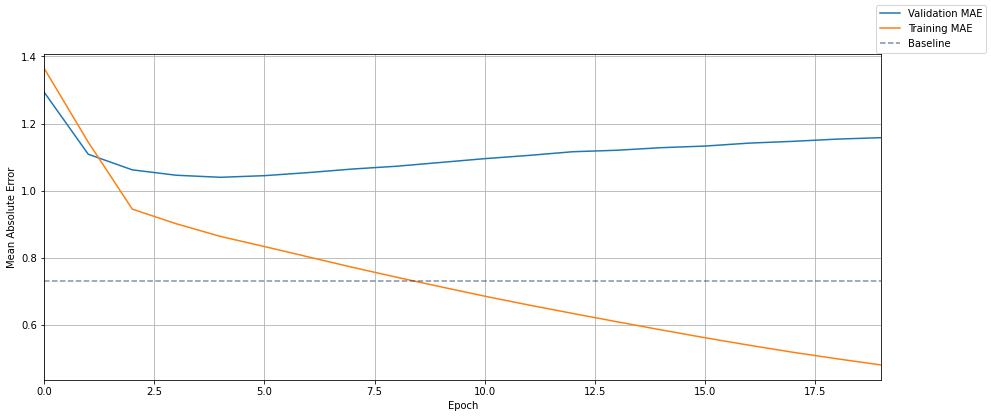

In [79]:
user_id_input = keras.Input(shape=(1,),name='user_id')
song_id_input = keras.Input(shape=(1,),name='song_id')

song_embedding_size = 32
user_embedding_size = 32

user_embedded = keras.layers.Embedding(df["'userID'"].max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
song_embedded = keras.layers.Embedding(df["'songID'"].max()+1, song_embedding_size, 
                                        input_length=1, name='movie_embedding')(song_id_input)

concatenated = keras.layers.Concatenate()([user_embedded, song_embedded])
out = keras.layers.Flatten()(concatenated)

out = keras.layers.Dense(32, activation='relu')(out)
out = keras.layers.Dense(4, activation='relu')(out)

out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

modelNN = keras.Model(
    inputs = [user_id_input, song_id_input],
    outputs = out,
)

modelNN.compile(tf.train.AdamOptimizer(0.005),loss='MSE',metrics=['MAE'])

historyNN = modelNN.fit([df["'userID'"], df["'songID'"]],df.y,batch_size=100000,epochs=20,validation_split=.05)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(historyNN.epoch, historyNN.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(historyNN.epoch, historyNN.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=historyNN.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

2. Modelo producto escalar.

Train on 1900000 samples, validate on 100000 samples
Epoch 1/20
1900000/1900000 [==============================] - 1s 1us/sample - loss: 2.4140 - mean_absolute_error: 1.3883 - val_loss: 2.4143 - val_mean_absolute_error: 1.3880
Epoch 2/20
1900000/1900000 [==============================] - 1s 1us/sample - loss: 2.4109 - mean_absolute_error: 1.3874 - val_loss: 2.4143 - val_mean_absolute_error: 1.3880
Epoch 3/20
1900000/1900000 [==============================] - 1s 1us/sample - loss: 2.4077 - mean_absolute_error: 1.3864 - val_loss: 2.4143 - val_mean_absolute_error: 1.3880
Epoch 4/20
1900000/1900000 [==============================] - 1s 1us/sample - loss: 2.4035 - mean_absolute_error: 1.3851 - val_loss: 2.4143 - val_mean_absolute_error: 1.3880
Epoch 5/20
1900000/1900000 [==============================] - 1s 1us/sample - loss: 2.3978 - mean_absolute_error: 1.3834 - val_loss: 2.4142 - val_mean_absolute_error: 1.3879
Epoch 6/20
1900000/1900000 [==============================] - 1s 1us/sample -

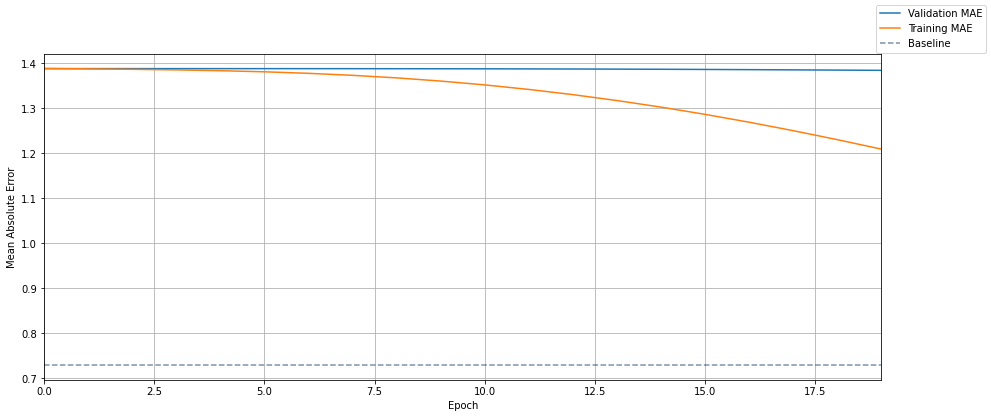

In [81]:
song_embedding_size = user_embedding_size = 16

user_id_input = keras.Input(shape=(1,), name='user_id')
song_id_input = keras.Input(shape=(1,), name='song_id')

user_embedded = keras.layers.Embedding(df["'userID'"].max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
song_embedded = keras.layers.Embedding(df["'songID'"].max()+1, song_embedding_size, 
                                        input_length=1, name='song_embedding')(song_id_input)

dotted = keras.layers.Dot(2)([user_embedded, song_embedded])
out = keras.layers.Flatten()(dotted)

modelDot = keras.Model(
    inputs = [user_id_input, song_id_input],
    outputs = out,
)

modelDot.compile(tf.train.AdamOptimizer(0.001),loss='MSE',metrics=['MAE'])

historyDot = modelDot.fit([df["'userID'"], df["'songID'"]],df.y,batch_size=100000,epochs=20,validation_split=.05)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(historyDot.epoch, historyDot.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(historyDot.epoch, historyDot.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=historyDot.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

Recuerda guardar este notebook en el repositorio de GitHub con la opción Save a copy in GitHub del menú File.  